In [ ]:
!pip install transformers datasets peft accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
from peft import PrefixTuningConfig, get_peft_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def create_peft_model(base_model, method, prefix_tokens):
  if method == "prefix":
    config = PrefixTuningConfig(
      num_virtual_tokens=prefix_tokens,
      task_type="SEQ_CLS"
    )
  else:
    raise ValueError("PEFT method not implemented")

  peft_model = get_peft_model(base_model, config)
  return peft_model

In [ ]:
def count_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def prepare_imdb_dataset(tokenizer, prefix_tokens):
    max_len = 512 - prefix_tokens

    raw_dataset = load_dataset("imdb")
    split = raw_dataset["train"].train_test_split(test_size=0.1, seed=42)
    data = DatasetDict({
        "train": split["train"],
        "validation": split["test"],
    })

    def encode(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_len,
        )

    encoded = data.map(encode, batched=True)
    encoded = encoded.rename_column("label", "labels")
    encoded.set_format("torch", columns=[
        "input_ids", "token_type_ids", "attention_mask", "labels"
    ])
    return encoded

In [ ]:
def prepare_tweet_dataset(tokenizer, prefix_tokens):
    max_len = 512 - prefix_tokens

    def encode(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_len,
        )

    raw_dataset = load_dataset("tweet_eval", "emotion")
    encoded = raw_dataset.map(encode, batched=True)
    encoded = encoded.rename_column("label", "labels")
    encoded.set_format("torch", columns=[
        "input_ids", "token_type_ids", "attention_mask", "labels"
    ])
    return encoded

In [ ]:
def prepare_tweet_sentiment_dataset(tokenizer, prefix_tokens):
    max_len = 512 - prefix_tokens

    def encode(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_len,
        )

    raw_dataset = load_dataset("tweet_eval", "sentiment")
    encoded = raw_dataset.map(encode, batched=True)
    encoded = encoded.rename_column("label", "labels")
    encoded.set_format("torch", columns=[
        "input_ids", "token_type_ids", "attention_mask", "labels"
    ])
    return encoded

In [ ]:
def prepare_mrpc_dataset(tokenizer, prefix_tokens):
  max_len = 512 - prefix_tokens

  def encode(examples):
    return tokenizer(
      examples['sentence1'],
      examples['sentence2'],
      truncation=True,
      padding='max_length',
      max_length=max_len
    )

  raw_dataset = load_dataset("glue", "mrpc")
  encoded = raw_dataset.map(encode, batched=True)
  encoded = encoded.rename_column("label", "labels")
  encoded.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])

  return encoded

In [ ]:
def prepare_rte_dataset(tokenizer, prefix_tokens):
  max_len = 512 - prefix_tokens

  def encode(examples):
    return tokenizer(
      examples['sentence1'],
      examples['sentence2'],
      truncation=True,
      padding='max_length',
      max_length=max_len
    )

  raw_dataset = load_dataset("glue", "rte")
  encoded = raw_dataset.map(encode, batched=True)
  encoded = encoded.rename_column("label", "labels")
  encoded.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])

  return encoded

In [ ]:
def prepare_sst2_dataset(tokenizer, prefix_tokens):
  max_len = 512 - prefix_tokens

  def encode(examples):
    return tokenizer(
      examples['sentence'],
      truncation=True,
      padding='max_length',
      max_length=max_len
    )

  raw_dataset = load_dataset("glue", "sst2")
  encoded = raw_dataset.map(encode, batched=True)
  encoded = encoded.rename_column("label", "labels")
  encoded.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

  return encoded

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def run_imdb_experiment(method, prefix_tokens):
    imdb_encoded = prepare_imdb_dataset(tokenizer, prefix_tokens)

    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    if prefix_tokens == 0:
        print("Running baseline with no prefix tuning.")
        tuned_model = model
    else:
        tuned_model = create_peft_model(model, method, prefix_tokens)

    trainable_params = count_trainable_parameters(tuned_model)
    print("Trainable params:", trainable_params)

    training_args = TrainingArguments(
        output_dir=f"./{method}_{prefix_tokens}_imdb_output",
        eval_strategy="epoch",
        learning_rate=1e-4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        logging_steps=50,
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=tuned_model,
        args=training_args,
        train_dataset=imdb_encoded["train"],
        eval_dataset=imdb_encoded["validation"],
        compute_metrics=lambda p: {
            "accuracy": (np.argmax(p.predictions, axis=1) == p.label_ids).mean()
        }
    )

    trainer.train()
    metrics = trainer.evaluate(imdb_encoded["validation"])
    return metrics, trainable_params

Running experiment with prefix_tokens = 1


Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 19970


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mitchell-wang (mitchell-wang-duke-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.617600,0.607859,0.716400
2,0.594100,0.578742,0.718800
3,0.585300,0.572243,0.721600


Running experiment with prefix_tokens = 5


Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 93698


Epoch,Training Loss,Validation Loss,Accuracy
1,0.601700,0.589053,0.739600
2,0.553700,0.544551,0.749600
3,0.549100,0.532929,0.750400


Running experiment with prefix_tokens = 30


Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 554498


Epoch,Training Loss,Validation Loss,Accuracy
1,0.594900,0.570119,0.736400
2,0.517100,0.491463,0.777200
3,0.493300,0.472242,0.784400


   prefix_tokens  trainable_params  accuracy
0              1             19970    0.7216
1              5             93698    0.7504
2             30            554498    0.7844


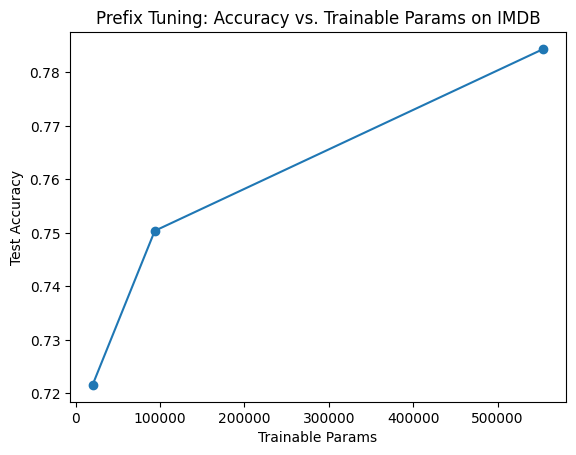

In [ ]:
prefix_lengths = [1, 5, 30]

results = []
for p in prefix_lengths:
  print(f"Running experiment with prefix_tokens = {p}")

  prefix_results, trainable_params = run_imdb_experiment(method="prefix", prefix_tokens=p)

  results.append({
    "prefix_tokens": p,
    "trainable_params": trainable_params,
    "accuracy": prefix_results["eval_accuracy"]
  })

df_results = pd.DataFrame(results)
print(df_results)

plt.figure()
plt.plot(df_results["trainable_params"], df_results["accuracy"], marker='o')
plt.xlabel("Trainable Params")
plt.ylabel("Test Accuracy")
plt.title("Prefix Tuning: Accuracy vs. Trainable Params on IMDB")
plt.show()

In [ ]:
def run_tweet_experiment(method, prefix_tokens):
    tweet_encoded = prepare_tweet_dataset(tokenizer, prefix_tokens)

    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
    if prefix_tokens == 0:
        print("Running baseline with no prefix tuning.")
        tuned_model = model
    else:
        tuned_model = create_peft_model(model, method, prefix_tokens)

    trainable_params = count_trainable_parameters(tuned_model)
    print("Trainable params:", trainable_params)

    training_args = TrainingArguments(
        output_dir=f"./{method}_{prefix_tokens}_tweet_output",
        eval_strategy="epoch",
        learning_rate=1e-4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        logging_steps=50,
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=tuned_model,
        args=training_args,
        train_dataset=tweet_encoded["train"],
        eval_dataset=tweet_encoded["validation"],
        compute_metrics=lambda p: {
            "accuracy": (np.argmax(p.predictions, axis=1) == p.label_ids).mean()
        }
    )

    trainer.train()
    metrics = trainer.evaluate(tweet_encoded["validation"])
    return metrics, trainable_params

Running experiment with prefix_tokens = 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 21508


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mitchell-wang (mitchell-wang-duke-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,1.268800,1.249022,0.427807
2,1.236300,1.236662,0.427807
3,1.248300,1.231908,0.427807


Running experiment with prefix_tokens = 5


Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 95236


Epoch,Training Loss,Validation Loss,Accuracy
1,1.275600,1.252577,0.427807
2,1.230900,1.241058,0.427807
3,1.248900,1.236337,0.425134


Running experiment with prefix_tokens = 30


Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 556036


Epoch,Training Loss,Validation Loss,Accuracy
1,1.270500,1.251103,0.425134
2,1.240800,1.247028,0.427807
3,1.257900,1.242903,0.427807


   prefix_tokens  trainable_params  accuracy
0              1             21508  0.427807
1              5             95236  0.425134
2             30            556036  0.427807


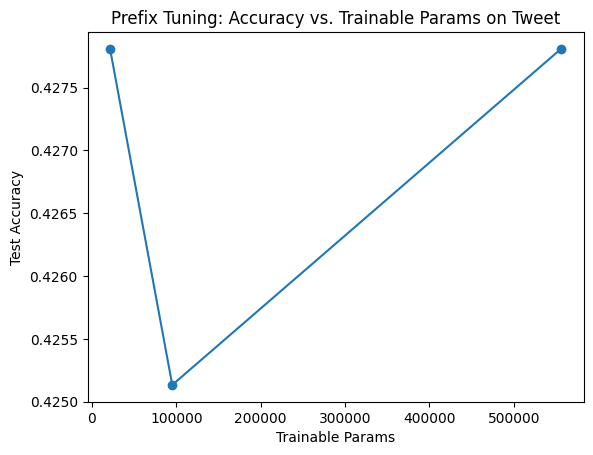

In [ ]:
prefix_lengths = [1, 5, 30]

results = []
for p in prefix_lengths:
  print(f"Running experiment with prefix_tokens = {p}")

  prefix_results, trainable_params = run_tweet_experiment(method="prefix", prefix_tokens=p)

  results.append({
    "prefix_tokens": p,
    "trainable_params": trainable_params,
    "accuracy": prefix_results["eval_accuracy"]
  })

df_results = pd.DataFrame(results)
print(df_results)

plt.figure()
plt.plot(df_results["trainable_params"], df_results["accuracy"], marker='o')
plt.xlabel("Trainable Params")
plt.ylabel("Test Accuracy")
plt.title("Prefix Tuning: Accuracy vs. Trainable Params on Tweet")
plt.show()

In [ ]:
def run_tweet_sentiment_experiment(method, prefix_tokens):
    tweet_encoded = prepare_tweet_sentiment_dataset(tokenizer, prefix_tokens)

    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
    if prefix_tokens == 0:
        print("Running baseline with no prefix tuning.")
        tuned_model = model
    else:
        tuned_model = create_peft_model(model, method, prefix_tokens)

    trainable_params = count_trainable_parameters(tuned_model)
    print("Trainable params:", trainable_params)

    training_args = TrainingArguments(
        output_dir=f"./{method}_{prefix_tokens}_tweet_sentiment_output",
        eval_strategy="epoch",
        learning_rate=1e-4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        logging_steps=50,
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=tuned_model,
        args=training_args,
        train_dataset=tweet_encoded["train"],
        eval_dataset=tweet_encoded["validation"],
        compute_metrics=lambda p: {
            "accuracy": (np.argmax(p.predictions, axis=1) == p.label_ids).mean()
        }
    )

    trainer.train()
    metrics = trainer.evaluate(tweet_encoded["validation"])
    return metrics, trainable_params

Running experiment with prefix_tokens = 1


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 20739


Epoch,Training Loss,Validation Loss,Accuracy
1,0.931100,0.948355,0.542500
2,0.908800,0.924736,0.554000
3,0.917600,0.918055,0.552500


Running experiment with prefix_tokens = 5


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 94467


Epoch,Training Loss,Validation Loss,Accuracy
1,0.949100,0.964707,0.533000
2,0.911900,0.925640,0.562000
3,0.914800,0.913021,0.559000


Running experiment with prefix_tokens = 30


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 555267


Epoch,Training Loss,Validation Loss,Accuracy
1,0.933100,0.942124,0.542500
2,0.879300,0.878542,0.575500
3,0.866600,0.859206,0.584500


   prefix_tokens  trainable_params  accuracy
0              1             20739    0.5525
1              5             94467    0.5590
2             30            555267    0.5845


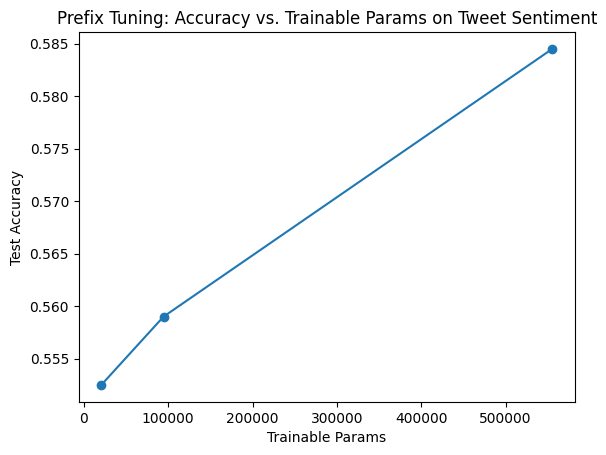

In [ ]:
prefix_lengths = [1, 5, 30]

results = []
for p in prefix_lengths:
  print(f"Running experiment with prefix_tokens = {p}")

  prefix_results, trainable_params = run_tweet_sentiment_experiment(method="prefix", prefix_tokens=p)

  results.append({
    "prefix_tokens": p,
    "trainable_params": trainable_params,
    "accuracy": prefix_results["eval_accuracy"]
  })

df_results = pd.DataFrame(results)
print(df_results)

plt.figure()
plt.plot(df_results["trainable_params"], df_results["accuracy"], marker='o')
plt.xlabel("Trainable Params")
plt.ylabel("Test Accuracy")
plt.title("Prefix Tuning: Accuracy vs. Trainable Params on Tweet Sentiment")
plt.show()

In [ ]:
def run_mrpc_experiment(method, prefix_tokens):
  mrpc_encoded = prepare_mrpc_dataset(tokenizer, prefix_tokens)

  model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
  if prefix_tokens == 0:
    print("Running baseline with no prefix tuning.")
    tuned_model = model
  else:
    tuned_model = create_peft_model(model, method, prefix_tokens)

  trainable_params = count_trainable_parameters(tuned_model)
  print("Trainable params:", trainable_params)

  training_args = TrainingArguments(
    output_dir=f"./{method}_{prefix_tokens}_mrpc_output",
    eval_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
  )

  trainer = Trainer(
    model=tuned_model,
    args=training_args,
    train_dataset=mrpc_encoded["train"],
    eval_dataset=mrpc_encoded["validation"],
    compute_metrics=lambda p: {
      "accuracy": (np.argmax(p.predictions, axis=1) == p.label_ids).mean()
    }
  )

  trainer.train()
  metrics = trainer.evaluate(mrpc_encoded["validation"])
  return metrics, trainable_params

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Running experiment with prefix_tokens = 1


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 19970


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mitchell-wang (mitchell-wang-duke-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.632400,0.620304,0.683824
2,0.638900,0.620006,0.683824
3,0.636900,0.619581,0.683824


Running experiment with prefix_tokens = 5


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 93698


Epoch,Training Loss,Validation Loss,Accuracy
1,0.645600,0.621830,0.683824
2,0.641600,0.620975,0.683824
3,0.641000,0.620833,0.683824


Running experiment with prefix_tokens = 30


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 554498


Epoch,Training Loss,Validation Loss,Accuracy
1,0.637100,0.618945,0.683824
2,0.639700,0.616522,0.683824
3,0.626800,0.615444,0.683824


   prefix_tokens  trainable_params  accuracy
0              1             19970  0.683824
1              5             93698  0.683824
2             30            554498  0.683824


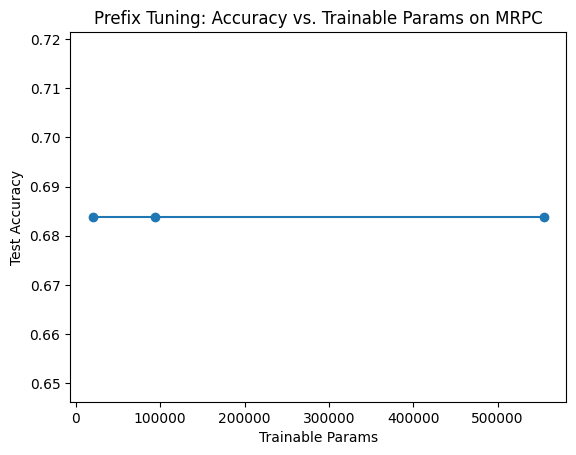

In [ ]:
prefix_lengths = [1, 5, 30]

results = []
for p in prefix_lengths:
  print(f"Running experiment with prefix_tokens = {p}")

  prefix_results, trainable_params = run_mrpc_experiment(method="prefix", prefix_tokens=p)

  results.append({
    "prefix_tokens": p,
    "trainable_params": trainable_params,
    "accuracy": prefix_results["eval_accuracy"]
  })

df_results = pd.DataFrame(results)
print(df_results)

plt.figure()
plt.plot(df_results["trainable_params"], df_results["accuracy"], marker='o')
plt.xlabel("Trainable Params")
plt.ylabel("Test Accuracy")
plt.title("Prefix Tuning: Accuracy vs. Trainable Params on MRPC")
plt.show()

In [ ]:
def run_rte_experiment(method, prefix_tokens):
  rte_encoded = prepare_rte_dataset(tokenizer, prefix_tokens)

  model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
  if prefix_tokens == 0:
    print("Running baseline with no prefix tuning.")
    tuned_model = model
  else:
    tuned_model = create_peft_model(model, method, prefix_tokens)

  trainable_params = count_trainable_parameters(tuned_model)
  print("Trainable params:", trainable_params)

  training_args = TrainingArguments(
    output_dir=f"./{method}_{prefix_tokens}_rte_output",
    eval_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
  )

  trainer = Trainer(
    model=tuned_model,
    args=training_args,
    train_dataset=rte_encoded["train"],
    eval_dataset=rte_encoded["validation"],
    compute_metrics=lambda p: {
      "accuracy": (np.argmax(p.predictions, axis=1) == p.label_ids).mean()
    }
  )

  trainer.train()
  metrics = trainer.evaluate(rte_encoded["validation"])
  return metrics, trainable_params

Running experiment with prefix_tokens = 1


train-00000-of-00001.parquet:   0%|          | 0.00/584k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/621k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 19970


Epoch,Training Loss,Validation Loss,Accuracy
1,0.704300,0.715509,0.472924
2,0.700900,0.694336,0.472924
3,0.694600,0.692561,0.483755


Running experiment with prefix_tokens = 5


Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 93698


Epoch,Training Loss,Validation Loss,Accuracy
1,0.702500,0.713974,0.472924
2,0.700900,0.693109,0.472924
3,0.690000,0.692586,0.483755


Running experiment with prefix_tokens = 30


Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 554498


Epoch,Training Loss,Validation Loss,Accuracy
1,0.698700,0.712974,0.472924
2,0.697900,0.689375,0.498195
3,0.688400,0.688831,0.498195


   prefix_tokens  trainable_params  accuracy
0              1             19970  0.483755
1              5             93698  0.483755
2             30            554498  0.498195


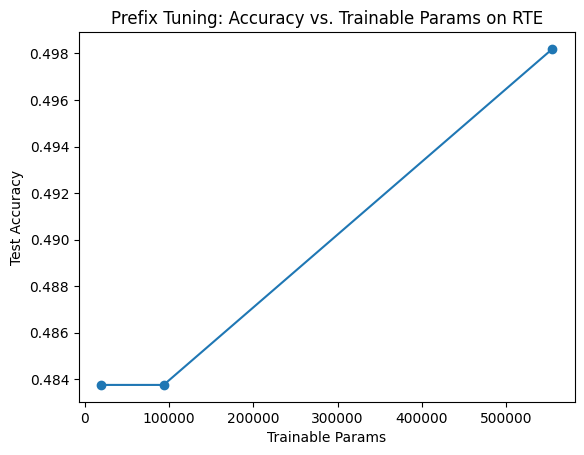

In [ ]:
prefix_lengths = [1, 5, 30]

results = []
for p in prefix_lengths:
  print(f"Running experiment with prefix_tokens = {p}")

  prefix_results, trainable_params = run_rte_experiment(method="prefix", prefix_tokens=p)

  results.append({
    "prefix_tokens": p,
    "trainable_params": trainable_params,
    "accuracy": prefix_results["eval_accuracy"]
  })

df_results = pd.DataFrame(results)
print(df_results)

plt.figure()
plt.plot(df_results["trainable_params"], df_results["accuracy"], marker='o')
plt.xlabel("Trainable Params")
plt.ylabel("Test Accuracy")
plt.title("Prefix Tuning: Accuracy vs. Trainable Params on RTE")
plt.show()

In [ ]:
def run_sst2_experiment(method, prefix_tokens):
  sst2_encoded = prepare_sst2_dataset(tokenizer, prefix_tokens)

  model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
  if prefix_tokens == 0:
    print("Running baseline with no prefix tuning.")
    tuned_model = model
  else:
    tuned_model = create_peft_model(model, method, prefix_tokens)

  trainable_params = count_trainable_parameters(tuned_model)
  print("Trainable params:", trainable_params)

  training_args = TrainingArguments(
    output_dir=f"./{method}_{prefix_tokens}_sst2_output",
    eval_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
  )

  trainer = Trainer(
    model=tuned_model,
    args=training_args,
    train_dataset=sst2_encoded["train"],
    eval_dataset=sst2_encoded["validation"],
    compute_metrics=lambda p: {
        "accuracy": (np.argmax(p.predictions, axis=1) == p.label_ids).mean()
    }
  )

  trainer.train()
  metrics = trainer.evaluate(sst2_encoded["validation"])
  return metrics, trainable_params

Running experiment with prefix_tokens = 1


train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 19970


Epoch,Training Loss,Validation Loss,Accuracy
1,0.535600,0.507358,0.778670
2,0.436600,0.436288,0.808486
3,0.435400,0.420685,0.816514


Running experiment with prefix_tokens = 5


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 93698


Epoch,Training Loss,Validation Loss,Accuracy
1,0.488500,0.452633,0.788991
2,0.380300,0.373059,0.841743
3,0.381200,0.365008,0.847477


Running experiment with prefix_tokens = 30


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 554498


Epoch,Training Loss,Validation Loss,Accuracy
1,0.365700,0.333103,0.861239
2,0.315500,0.309600,0.868119
3,0.325700,0.307504,0.871560


   prefix_tokens  trainable_params  accuracy
0              1             19970  0.816514
1              5             93698  0.847477
2             30            554498  0.871560


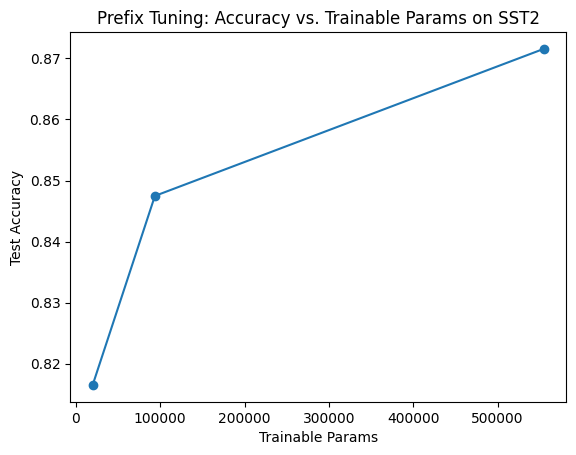

In [ ]:
prefix_lengths = [1, 5, 30]

results = []
for p in prefix_lengths:
  print(f"Running experiment with prefix_tokens = {p}")

  prefix_results, trainable_params = run_sst2_experiment(method="prefix", prefix_tokens=p)

  results.append({
    "prefix_tokens": p,
    "trainable_params": trainable_params,
    "accuracy": prefix_results["eval_accuracy"]
  })

df_results = pd.DataFrame(results)
print(df_results)

plt.figure()
plt.plot(df_results["trainable_params"], df_results["accuracy"], marker='o')
plt.xlabel("Trainable Params")
plt.ylabel("Test Accuracy")
plt.title("Prefix Tuning: Accuracy vs. Trainable Params on SST2")
plt.show()